# 2.3 What are autoencoders to GANs?
- Key distinction
 - autoencoders: end-to-end train the whole network with one loss function.
 - GANs: distinct loss functions for the Generator and the Discriminator.
   - GANs have two competing objectives that cannot be written in one function.
- GANs in Action本の全部実践notebookはここにある。https://github.com/GANs-in-Action/gans-in-action
- また、たくさん種類のGANの実現はここにある。
 - Kerasで：https://github.com/eriklindernoren/Keras-GAN
 - PyTorchで：https://github.com/eriklindernoren/PyTorch-GAN

# 2.7 Variational Autoencoder code

## Step 1: Standard imports and Setting hyperparameters

In [28]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [29]:
batch_size = 100
original_dim = 784 # 28*28
latent_dim = 2 # bivariate Gaussian.つまりz_meanやz_log_varのサイズは全部1*2です。ちょっと小さすぎじゃない？
intermediate_dim = 256 # input層やlatent層の中間層のサイズ。
epochs = 50
epsilon_std = 1.0

## Step 2: Creating the sampling helper function
- encoderの結果としてのz_mean,z_log_varからsamplingする。
- reparametrization trickを使っている。VAE & GAN勉強会資料を参考してください。https://github.com/youngsend/DeepLearningAndKeras/blob/master/Deep-Learning-Ian-Goodfellow/Chapter20.9-20.10_VAE_GAN.pdf
- 名前の通り、$z\_log\_var=log(\sigma^2)=2log(\sigma)$.
 - だから$y=\mu+\sigma z=\mu + exp(z\_log\_var / 2)z$.
 - $z\sim\mathcal{N}(z;0,1)$.

In [30]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    # K.shape(z_mean)[0]はbatch_sizeです。つまり例えばinputの画像数。epsilonのサイズはbatch_size*latent_dim=100*2
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                             stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Step 3: The Encoder

In [31]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

In [32]:
encoder.summary()
# Output Shapeの中のNoneはbatch_sizeでしょう。
# Connected toを見てネットワークの構造が分かるでしょう。

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

# Step 4: The Decoder

In [33]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# sigmoidで(0,1)に変換して簡単に画像で表示できるから。
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")

In [34]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


# Step 5: The VAE: combine Encoder and Decoder

In [35]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined, name="vae")

In [36]:
vae.summary()
# encoderのoutputは[z_mean, z_log_var, z]なので、encoder(x)[2]がdecoderの入力です。

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


# Step 6: Loss Function
- VAEのloss functionの導き出しは勉強会資料を参考してください。
 - https://github.com/youngsend/DeepLearningAndKeras/blob/master/Deep-Learning-Ian-Goodfellow/Chapter20.9-20.10_VAE_GAN.pdf
- 下記式のJはzのdimensionです。つまりlatent_dim。
- 下記式のLはsampling回数です。Monte Carlo方法で$\mathbb{E}_{z\sim q}logp(x|z)$を計算しているだけ。L回サンプリングして、L回の平均値を期待値として使う。実際はよく１にされるらしい。
<img src="img/vae-loss-2020-02-18 22-15-25.png" alt="vae loss function" width="600">

- binary cross-entropyで$logp(x|z)$を計算する理由は、KingmaのVAE論文から下記の式があるからだと思う。Dはxやyのdimensionだ。つまりoriginal_dim（画像サイズ）。
<img src="img/vae-cross-entropy-2020-02-18 23-36-39.png" width="600">

- vae_loss関数内binary cross-entropy lossを計算するときoriginal_dimを掛ける理由は、kerasのbinary_crossentropyは平均値を返すからです。kerasのlosses.pyを見れば分かる。https://github.com/keras-team/keras/blob/master/keras/losses.py
- でもソースコードから見ると、K.binary_crossentropyはまだsumを返しているでしょう。
<img src="img/keras-binary-crossentropy-2020-02-19 00-01-19.png" width="600">

In [37]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    # axis=-1。batch_size*latent_dimからbatch_size*1になる。
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss) # batchの平均値を計算
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

# Step 7: Creating train/test split

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # yはいらないけど。

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [27]:
x_train.shape

(60000, 784)

In [39]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Epoch 1/50
60000/60000 [==============================] - 2s 37us/step - loss: 191.4731
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 171.1757
Epoch 3/50
60000/60000 [==============================] - 2s 33us/step - loss: 167.6236
Epoch 4/50
60000/60000 [==============================] - 2s 32us/step - loss: 165.2431
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 163.6975
Epoch 6/50
60000/60000 [==============================] - 2s 33us/step - loss: 162.5399
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: 161.6537
Epoch 8/50
60000/60000 [==============================] - 2s 34us/step - loss: 160.9294
Epoch 9/50
60000/60000 [==============================] - 2s 33us/step - loss: 160.2956
Epoch 10/50
60000/60000 [==============================] - 2s 33us/step - loss: 159.6983
Epoch 11/50
60000/60000 [==============================] - 2s 33us/step - loss: 159.1572
Epoch 12/50
60000/60000 [=====

# Step 8: Latent Space（Encoderの結果を見る）
- y_testを利用して、clusterを見れる。下記の図を見ると、同じ数字はclusteringしているでしょう。つまり、多分decoderする時それぞれのcluster地域からはその数字が生成されるでしょう。

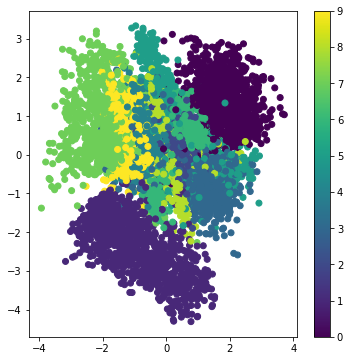

In [40]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0] # z_mean
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

# Step 9: Latent Spaceを歩きながらそこから数字を生成しよう！
- Gaussian分布のzサンプルの生成方法：ppf。
 - ppfはcdfの逆。
 - cdf:入力x,出力確率p(X<=x)。
 - ppf:入力確率p,出力はこのpに対するx。
 - 参考：http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/en_Tanagra_Calcul_P_Value.pdf
- 例えば、下記の図のように、
    - $norm.cdf(1.65)=0.9505285$
    - $norm.ppf(0.9595285)=1.65$
    - まだ$\mu=0,\sigma=1$
<img src="img/cdf-and-ppf-2020-02-19 01-25-57.png" width="700">

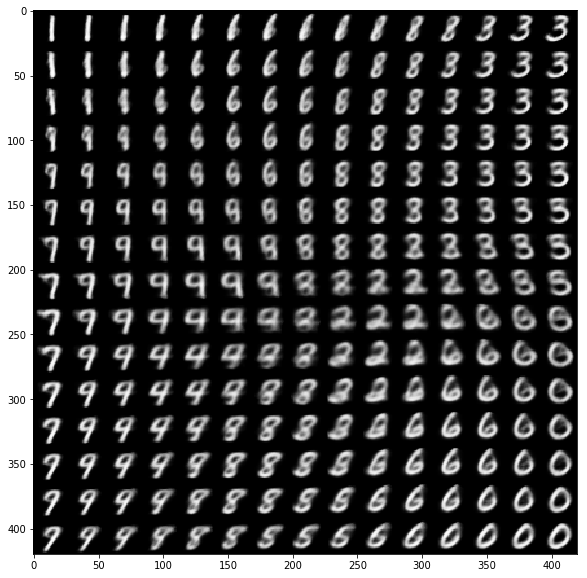

In [50]:
n = 15 # 横縦各15画像
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 正規分布のzを生成する
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) # 0.05 ~ 0.95は信頼区間でしょう。
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x): # 何でxiやyiが逆だろう？ふざけ？
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,
              j * digit_size : (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()